# Project 2: Image Enhancement


We propose four ways to enhance an image:

* Noise Reduction:
  1. Manual, with a median filter
  2. Automatic, with one or more median filters, and the co-occurence matrix
  
  
* Auto-leveling: can be used on both RGB and HSV encoded images, either with given lower and upper bound, or with percentiles


* Gamma-correction, by using the usual formula:
  1. With provided gamma
  2. With gamma computed based on the "Value" channel


* Increase saturation, by a given factor


## 1. Noise Reduction

### 1.1 Functions to add noise

To test the noise reductions techniques, we are going to need some noisy images. The two functions below will be used for that:

* $add\_noise\_3d$ takes as input an image and the number of pixels that will be altered. It then chooses that many random coordinates, and replaces their value by a triplet of random numbers in [0, 255]

* $add\_noise\_percentage$ takes a percentage instead, computed the number of pixels based on the image size, then calls add_noise_3d.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
%matplotlib inline


def add_noise_3d(im, n):
    im2 = im.copy()
    size_x, size_y = im.shape[1], im.shape[0]
    
    rand_x = np.random.randint(0, size_x, size=(1, n))[0]    # vector of n random numbers in range [0, size_x-1]
    rand_y = np.random.randint(0, size_y, size=(1, n))[0]    # vector of n random numbers in range [0, size_y-1]

    for i in range(n):
        rand_color = np.random.randint(0, 256, size=(1,3))   # vector of 3 random numbers in range [0, 255]

        im2[rand_y[i], rand_x[i]] = rand_color
        
    return im2

def add_noise_percentage(im, percentage):
    n = im.shape[0] * im.shape[1] * percentage
    n = round(n)
    return add_noise_3d(im, n)




### 1.2 Manual Reduction

Manual noise reduction is done the same way as in the labs, i.e. with a median filter. The only difference is that images are 3-dimensional, and each channel is handled separately, and the image is then re-assembled. 

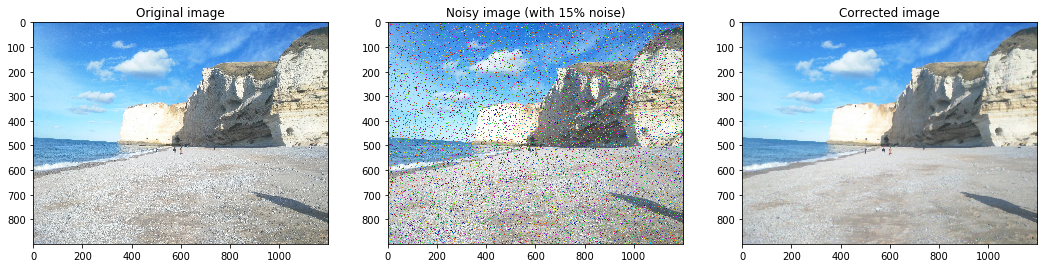

In [4]:
from skimage.filters.rank import median


def noise_reduction_median(im, size):
    neighbourhood = np.ones((size, size))
    im_median = np.dstack([median(im[:, :, 0], selem=neighbourhood),
                          median(im[:, :, 1], selem=neighbourhood),
                          median(im[:, :, 2], selem=neighbourhood)])
    return im_median


beach = imread("etretat.jpg")
beach_noisy = add_noise_percentage(beach, 0.15)
beach_corrected = noise_reduction_median(beach_noisy, 5)

plt.figure(figsize=(18, 20))
plt.subplot(1, 3, 1)
plt.imshow(beach)
plt.title("Original image")

plt.subplot(1, 3, 2)
plt.imshow(beach_noisy)
plt.title("Noisy image (with 15% noise)")

plt.subplot(1, 3, 3)
plt.imshow(beach_corrected)
plt.title("Corrected image")

plt.show()

### 1.3 Automatic Reduction

If the user doesn't know what size to use for the neighbourhood in the previous method (if the size is too small, some of the noise will remain; if it's too big, the image will be too blurry), an automatic method has been provided. It uses the values in the diagonal line in the co-occurence matrix of the image compared to the size of the image. More formally, it computes $ratio = \frac{\sum_{i=0}^{256} C[i, i]}{S}$, where C is the comatrix of the hue channel of the image, and S is the size of the image, i.e. the sum of all values in the comatrix.

If this value is high, the image is very "low-frequency", and vice-versa. We know that noise is, by definition, "high-frequency" and we can use that to know if the image is de-noised enough. First, let's see what typical values for that ratio could be. We'll use three images that are quite different, in their original form, and with different amounts of noise.

In [15]:
from skimage.color import rgb2hsv
from skimage.util import img_as_ubyte
from skimage.feature import greycomatrix

def comatrix_diagonal_ratio(im):
    im_h = img_as_ubyte(rgb2hsv(im)[:, :, 0])    # We use the hue channel
    
    comatrix = greycomatrix(im_h, [1], [-(np.pi/4)])[:,:,0,0]
    
    total = 0
    
    for i in range(256):
        total += comatrix[i, i]
    return total/comatrix.sum()


def compute_values(im):
    print("\toriginal: ", end=" ")
    ratio = comatrix_diagonal_ratio(im)
    print(ratio)
    for i in [0.1, 0.5, 0.75]:
        print("\t" + str(100*i) + "% noise:", end=" ")
        im_noisy = add_noise_percentage(im, i)
        ratio = comatrix_diagonal_ratio(im_noisy)
        print(ratio)
    print("\n")
    
    
beach = imread("etretat.jpg")
night = imread("night.jpg")
nyc   = imread("nyc.jpg")

print("beach:")
compute_values(beach)

print("night:")
compute_values(night)

print("nyc:")
compute_values(nyc)



beach:
	original:  0.40338027332751336
	10.0% noise: 0.33100442433952654
	50.0% noise: 0.1512244631000435
	75.0% noise: 0.09323676293091851


night:
	original:  0.8696407427983901
	10.0% noise: 0.7124836284198063
	50.0% noise: 0.3220720324389821
	75.0% noise: 0.19729608112762165


nyc:
	original:  0.36264160192365424
	10.0% noise: 0.2978894043836228
	50.0% noise: 0.13567969648495115
	75.0% noise: 0.08436291280468615




As expected, the values go down drastically with increasing noise. However, we also see that values for the original images can be very different. Indeed, some images (like nyc.jpg for example) can have a lot of variation without being noisy. We will choose 0.4 as a reasonable middle ground. We can thus define an automatic noise reduction method : We apply the previous method once (with neighbourhood of size 3), then we compute the diagonal ratio. We repeat while the ratio is lower than 0.4. Since some images may not reach that value even when they are cleaned, this will be applied maximum 3 times to avoid looping for too long and making the image too blurry.

In [16]:
def noise_reduction_auto(im):
    diagonal_ratio = comatrix_diagonal_ratio(im)
    im_cleaned = noise_reduction_median(im, 3)
    i = 0

    while (diagonal_ratio < 0.4 and i < 3):
        im_cleaned = noise_reduction_median(im_cleaned, 3)
        i += 1
        diagonal_ratio = comatrix_diagonal_ratio(im_cleaned)
        
    return im_cleaned, i

To test the method, we will add 80% of noise to the 3 images used previously and then apply the algorithm.

In [ ]:
beach = imread("etretat.jpg")
night = imread("night.jpg")
nyc   = imread("nyc.jpg")

beach_noisy = add_noise_percentage(beach, 0.8)
night_noisy = add_noise_percentage(night, 0.8)
nyc_noisy = add_noise_percentage(nyc, 0.8)

beach:  3
night:  3
nyc:  3


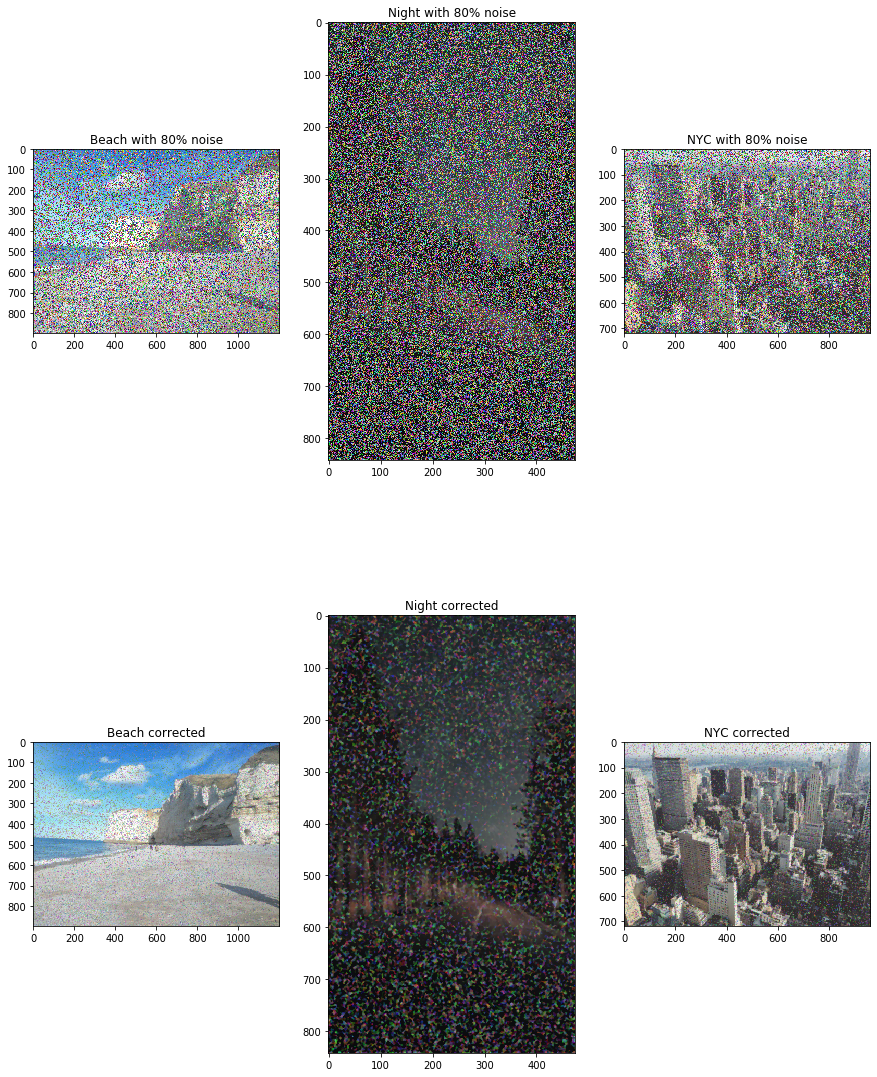

In [18]:

beach_corrected, iter_beach = noise_reduction_auto(beach_noisy)
night_corrected, iter_night = noise_reduction_auto(night_noisy)
nyc_corrected, iter_nyc = noise_reduction_auto(nyc_noisy)

print("beach: ", iter_beach)
print("night: ", iter_night)
print("nyc: ", iter_nyc)


plt.figure(figsize=(15, 20))

plt.subplot(2, 3, 1)
plt.imshow(beach_noisy)
plt.title("Beach with 80% noise")


plt.subplot(2, 3, 2)
plt.imshow(night_noisy)
plt.title("Night with 80% noise")

plt.subplot(2, 3, 3)
plt.imshow(nyc_noisy)
plt.title("NYC with 80% noise")

plt.subplot(2, 3, 4)
plt.imshow(beach_corrected)
plt.title("Beach corrected")

plt.subplot(2, 3, 5)
plt.imshow(night_corrected)
plt.title("Night corrected")

plt.subplot(2, 3, 6)
plt.imshow(nyc_corrected)
plt.title("NYC corrected")

plt.show()

The result is far from perfect :

* we still have a lot of noise in one image, and some of it in the two others
* if we zoom in, we will see that the images are quite blurry

However, I think that 80% of noise is quite a lot, and it's rather surprising that we still managed to retrieve most of the information in the images. This algorithm obviouly needs a lot more refining, but that would get very complex for this simple project.


## 2. Auto-level

### 2.1 With specified values

The 1D auto-level works exactly the same way as what we saw in the labs. For the 3D version, we simply apply the 1D version on all three channels. That means that the user must give two arrays of three values each, instead of simply two values. You will notice that the functions also take an additional parameter: $max\_val$. This is because we want to handle both rgb and hsv images. The values for $max\_val$ will be:

* 255 for rgb images
* 100 for hsv images, because we will first scale the image from 0 to 100

In [29]:
def auto_level(im, max_val, Tmin, Tmax):
    lut = np.arange(0, max_val+1)
    
    lut[Tmax:] = max_val
    lut[:Tmin] = 0

    lut[Tmin:Tmax] = (lut[Tmin:Tmax] - Tmin)*(max_val/(Tmax-Tmin))

    im_str = lut[im]
    return im_str


def auto_level_3d(im, max_val, Tmin, Tmax):
    im2 = np.zeros(im.shape)
    for i in range(3):
        im2[:, :, i] = auto_level(im[:, :, i], max_val, Tmin[i], Tmax[i])
    return im2.astype('uint8')


def hist(im, max_val):
    h = np.zeros((max_val+1,))
    for i in range(max_val+1):
        h[i] = (im == i).sum()
    return h


def show_3d_hist(im, max_val):
    r = hist(im[:, :, 0], max_val)
    g = hist(im[:, :, 1], max_val)
    b = hist(im[:, :, 2], max_val)
    
    plt.figure(figsize=(18, 12))
    plt.subplot(3, 1, 1)
    plt.plot(r)
    plt.title('red')
    plt.subplot(3, 1, 2)
    plt.plot(g)
    plt.title('green')
    plt.subplot(3, 1, 3)
    plt.plot(b)
    plt.title('blue')
    plt.show()

Here, we use the histograms of the "night.jpg" image to determine the right values for min and max. Thanks to the auto-level, the dark parts of the image become way more visible.

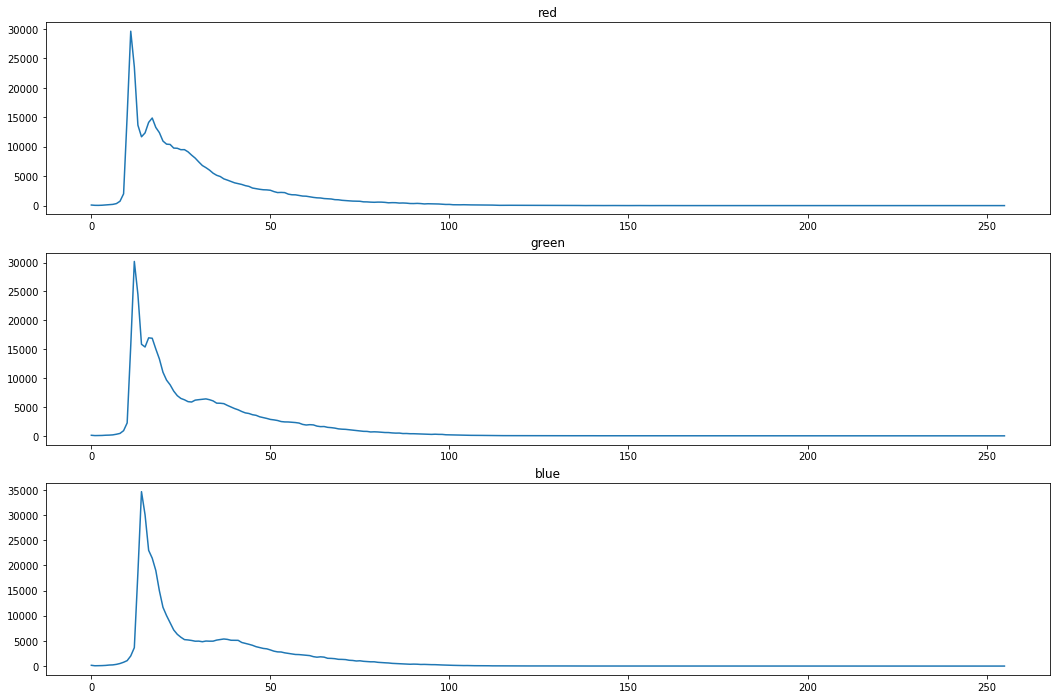

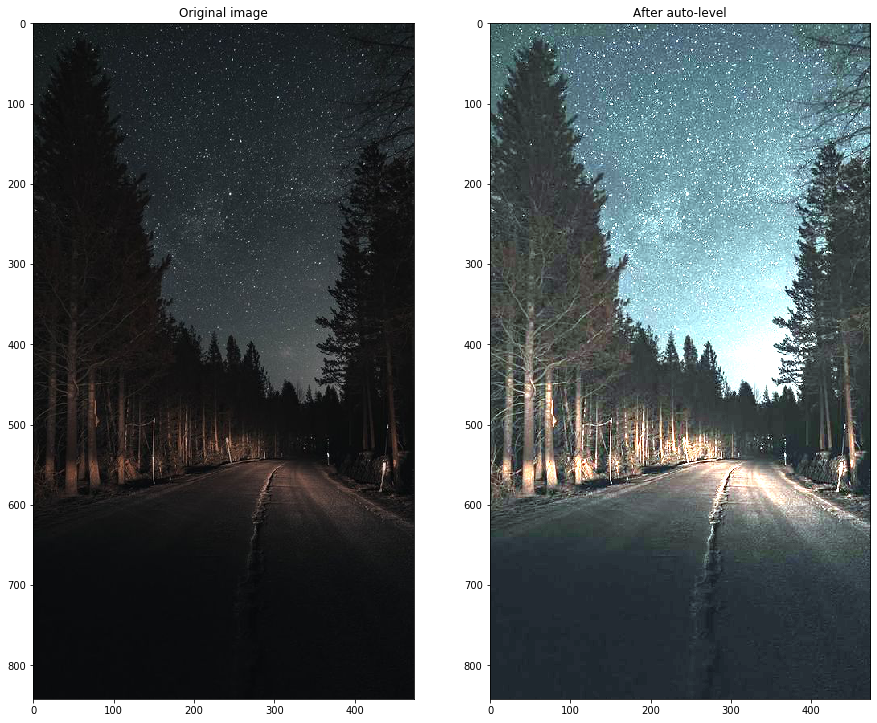

In [41]:
night = imread("night.jpg")

show_3d_hist(night, 255)

night_auto = auto_level_3d(night, 255, [0, 0, 0], [80, 70, 70])

plt.figure(figsize=(15, 20))
plt.subplot(1, 2, 1)
plt.imshow(night)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(night_auto)
plt.title("After auto-level")
plt.show()

### 2.2 With percentiles

Once again, this is mostly the same as what we saw in the labs, but adapted to both rgb and hsv images. We use the normalized cumulative histogram to compute Tmin and Tmax based on the percentile values. 

Note: for rgb images, you should use similar values for the percentiles in the three channels. In hsv images, you should not use the 'hue' channel. Otherwise, you would have some weird things happening to the colors.

In [32]:
def norm_cumulative_hist(im, max_val):
    h = np.zeros((max_val+1,))
    c = 0
    for i in range(max_val+1):
        c += (im == i).sum()
        h[i] = c
    h /= h.max()
    return h

def get_percentile_values(im, max_val, low_perc, high_perc):
    h = norm_cumulative_hist(im, max_val)

    low_val = 0
    high_val = max_val
    
    for i in range(max_val+1):
        if h[i] >= low_perc:
            low_val = i
            break
            
    for i in range(max_val, -1, -1):
        if h[i] <= high_perc:
            high_val = i
            break
    
    return low_val, high_val


def auto_level_percentile(im, max_val, low_perc, high_perc):
    
    low_val, high_val = get_percentile_values(im, max_val, low_perc, high_perc)
    return auto_level(im, max_val, low_val, high_val)

def auto_level_percentile_3d(im, max_val, low_perc, high_perc):
    im2 = np.zeros(im.shape)
    
    for i in range(3):
        im2[:, :, i] = auto_level_percentile(im[:, :, i], max_val, low_perc[i], high_perc[i])
        
    return im2

In the following example we stretch saturation and value a bit on the hsv image. We can see the colors become more "vibrant", and we have a larger range of darks.

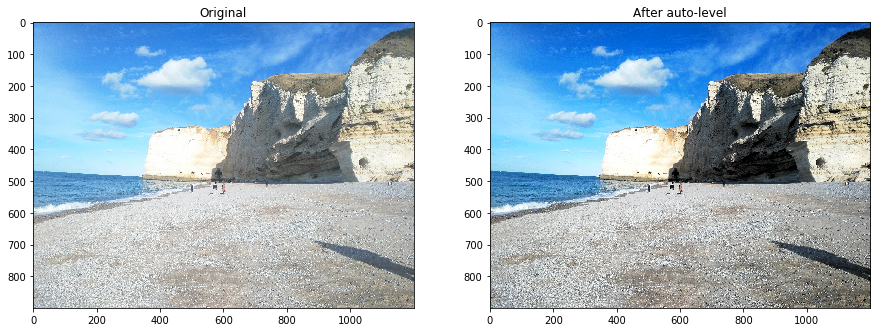

In [40]:
from skimage.color import rgb2hsv, hsv2rgb


beach = imread('etretat.jpg')

beach_hsv = rgb2hsv(beach)

beach_hsv = np.round(beach_hsv*100).astype('uint8')  # As we said, we scale to values to the range [0, 100]

beach_hsv_auto = auto_level_percentile_3d(beach_hsv, 100, [0, .01, .005], [1, .99, .99])  # we stretch saturation and 
                                                                                            # value, but not hue

beach_rgb_auto = hsv2rgb(beach_hsv_auto/100)


plt.figure(figsize=(15, 20))

plt.subplot(1, 2, 1)
plt.imshow(beach)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(beach_rgb_auto)
plt.title("After auto-level")
plt.show()


## 3. Gamma correction

### 3.1 Manual

Gamma correction is used to increase or decrease brighness in the image. It is similar to modifying the value channel in hsv, but that's not how we will do it here. Instead we will use $O = I^{\gamma}$ where I is the input image, in rgb format, scaled in [0, 1], O is the output, and $\gamma (> 0)$ determines what the operation will do:

* $\gamma > 1$ will make the image darker
* $\gamma < 1$ will make the image lighter

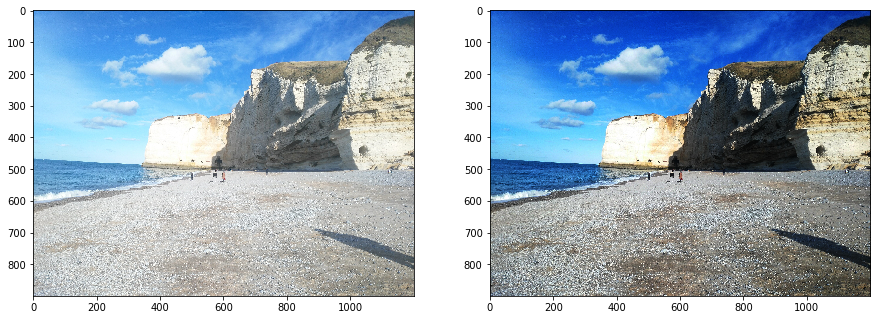

In [42]:
def gamma_correction(im, gamma=1):
    im2 = (im.copy()).astype('float64')
    im2 /= 255
    im2 = im2**gamma
    im2 = np.round(im2*255)
    return im2.astype('uint8')

beach = imread("etretat.jpg")
beach_gamma = gamma_correction(beach, 2.2)

plt.figure(figsize=(15, 20))

plt.subplot(1, 2, 1)
plt.imshow(beach)

plt.subplot(1, 2, 2)
plt.imshow(beach_gamma)

plt.show()

### 3.2 Automatic (with histogram)

Since gamma correction is about brightness, we are going to use the value channel of the image. We first compute the average of the channel on the entire image, then we find gamma we a simple formula: $\gamma = factor*avg\_value$. To find a good $factor$, we find by hand the optimal value for $\gamma$ for "etretat.jpg" (2.2) and "night.jpg (0.6). With the average values computed below, we find factors of 2.77 and 4.72 respectively. We will choose the mean value, 3.74.

In [45]:
def value_average(im):
    im_hsv = rgb2hsv(im)
    v = im_hsv[:, :, 2]
    size = im.shape[0] * im.shape[1]
    
    return v.sum()/size


beach = imread("etretat.jpg")
night = imread("night.jpg")

print("beach: ", value_average(beach))
print("night: ", value_average(night))
    

beach:  0.7947000835148877
night:  0.1273753509541965


We can now try that formula on another image, "nyc.jpg". The result looks reasonably good. 

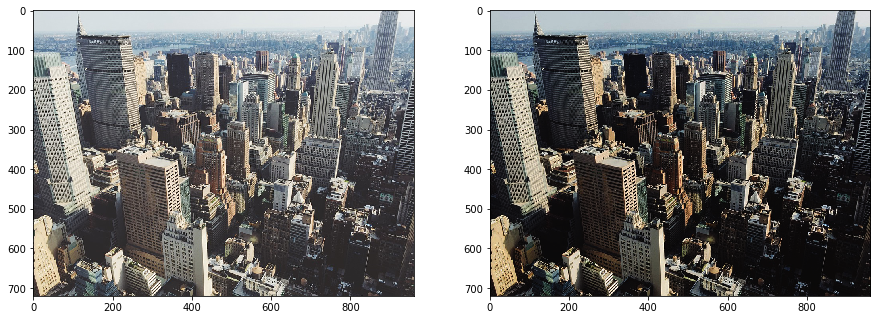

In [46]:
def auto_gamma(im):
    avg_value = value_average(im)
    
    gamma = avg_value * 3.74
    
    return gamma_correction(im, gamma)


nyc = imread("nyc.jpg")
nyc_gamma = auto_gamma(nyc)

plt.figure(figsize=(15, 20))

plt.subplot(1, 2, 1)
plt.imshow(nyc)

plt.subplot(1, 2, 2)
plt.imshow(nyc_gamma)

plt.show()


## 4. Increase saturation

This one is quite simple, we just multiply the saturation by a given factor, then cap the values at 1, and convert back to rgb. We could automatically compute the value of factor as done previously for gamma, but it would be repetitive. 

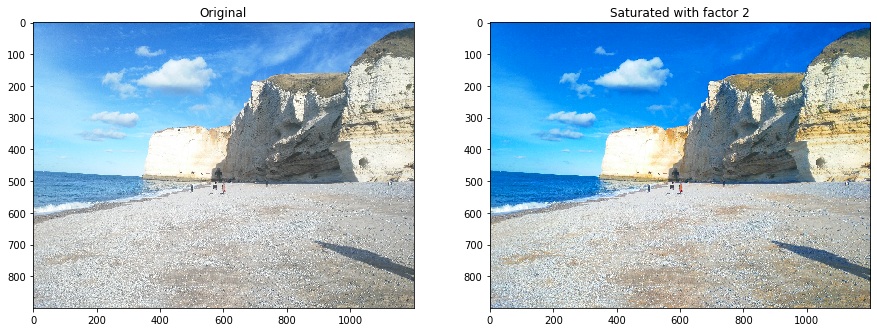

In [39]:
from skimage.color import rgb2hsv, hsv2rgb

def increase_saturation(im, factor):
    im_hsv = rgb2hsv(im)

    im_hsv[:, :, 1] *= factor
    im_hsv[im_hsv > 1] = 1

    return hsv2rgb(im_hsv)

beach = imread("etretat.jpg")
beach_sat = increase_saturation(beach, 2)

plt.figure(figsize=(15, 20))

plt.subplot(1, 2, 1)
plt.imshow(beach)
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(beach_sat)
plt.title("Saturated with factor 2")
plt.show()